### Random Forest Classification Model

A random forest model is a type of machine learning model that is used for both classification and regression tasks. 
<br>It is an ensemble model, meaning that it is made up of a collection of decision trees.
<br>multiple decision trees are created, each with a random subset of the available features and data points. 
<br>The trees are then combined to produce a final prediction. 
<br>
<br>In classification, the goal is to predict a categorical variable based on a set of input features.
<br>For our case - predicting the cost of damage for a fire incident - the set of input features is as follows:
<li><b>DateOfCall</b>: the month of the date when the fire incident was reported 
<li><b>PropertyType</b>: the type of location where the fire incident occured
<li><b>NumPumpsAttending</b>: the number of total fire pumps that were deployed to the fire incident location
<li><b>PumpHoursRoundUp</b>: the number of hours the fire pumps were used during the fire incident
<li><b>mean_temp</b>: mean daily temperature in Celsius (Cº)
<br>
<br>
The output of our classification model is the cost of damage in pound sterling (£).
<br>The cost value was originally a continuous numerical variable, but we convert it to a categorical variable by dividing and categorizing the numerical value in intervals of £300. 
<br>For example, all records of cost between £0.00 and £300.00 fall under category 1, all records of cost between £300.01 and £500.00 fall under category 2, and so on. 
<br>All records with costs larger than £1100.00 are categorized as category 5. 
<br>

#### Scikit-Learn Library

Our prediction model using the decision tree classifier is implemented with <b><i>scikit-learn</i></b> machine learning library in Python.<br>
Please follow the <b>scikit-learn</b>'s installation guide ([https://scikit-learn.org/stable/install.html](Hidden_landing_URL)) and have the library ready before running the code.<br>



#### 1. Importing Libraries

Following libraries and function are necessary to implement the decision tree prediction model.
<br>
<br>
<b> Pandas</b>: 
<li> Data manipulation library
<br><br>
<b> Numpy</b>: 
<li> Data manipulation library
<br><br>
<b> train_test_split </b> from sklearn.model_selection:
<li> Dividing the data into training and testing sets for model training and peformance analysis
<br><br>
<b> RandomForestClassifier </b> from sklearn:
<li> Scikit-learn's random forest classifier model library
<br><br>
<b> classification_report</b> from sklearn.metrics:
<li> Visualizing and measure the performance of the prediction model
<br><br>
<b> GridSearchCV</b> from sklearn.model_selection:
<li> Hyper parameter tuning
<br><br>
<b>pickle</b>:
<li> Saving and loading machine learning model

In [1]:
#import all necessary libraries for random forest model training and testing

#libraries for the data manipulation
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# library for data vizualization 
from matplotlib import pyplot as plt
# used for matplotlib in jupyter notebooks
%matplotlib inline 
import seaborn as sns

#library for random forest model
from sklearn.ensemble import RandomForestClassifier

# library for measuring the performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report

#for hyper parameter tunning
from sklearn.model_selection import GridSearchCV

#library for saving the final classifier model
import pickle

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})
import warnings
warnings.filterwarnings('ignore')

# from sklearn.preprocessing import MinMaxScaler
# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Datetime lib
from pandas import to_datetime
import itertools
import datetime

#### 2. Load Dataset

Loading the fire incident and weather dataset into <i>pandas</i> dataframe from CSV file.<br>
The features present in the cleaned dataset are listed below, alongside the type of data each of them holds.
<br>Only selected features will be used for the prediction model.
<br>Please refer to below for each data types' equivalent in Python.
<br><br>
Pandas' datatypes and their Python equivalents:
<li> int64 = int
<li> float64 = float
<li> object = string
<br><br>*Please refer to the <b><i>preprocessing</i></b> folder for detailed implementation on data cleaning.

In [2]:
data = pd.read_csv('preprocessing/data/london_clean.csv')
data.dtypes

DateOfCall             int64
CalYear                int64
HourOfCall             int64
IncidentGroup          int64
PropertyCategory       int64
PropertyType           int64
NumPumpsAttending      int64
PumpHoursRoundUp       int64
Notional Cost (£)      int64
Date                  object
cloud_cover          float64
sunshine             float64
global_radiation     float64
max_temp             float64
mean_temp            float64
min_temp             float64
precipitation        float64
pressure             float64
snow_depth           float64
CostCat                int64
dtype: object

#### 3. Feature Selection and Dataset Split

First, the entire dataset is split into input and output features - X and y respectively.
<br>We wish to predict feature in <i>y</i> based on features grouped in <i>X</i> used as input values.
<br>
<Br>
Both groups of input and output features are split into two subsets for their respective use with the help of Scikit-Learn's <i>train_test_split</i> function:
<li>67% of the dataset is used to train the random forest model
<li>33% of the dataset is used to test the performance of the random forest model
<br>
<br>
In <i>train_test_split</i> function, the <i>random_state</i> variable is specified to 42.
<br>This specification allows <i>train_test_split</i> function to generate the identical training and testing subsets every time it is called.
<br>This functionality allows all three prediction models to be trained on the same dataset, allowing better comparison between thier performance in the later step.

In [3]:
# do train and test split
X = data[['DateOfCall', 'PropertyType', 'NumPumpsAttending', 'PumpHoursRoundUp', 'mean_temp']]
y = data[['CostCat']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# print a small sample of train X and y
print(X_train[0:5])
print(y_train[0:5])

         DateOfCall  PropertyType  NumPumpsAttending  PumpHoursRoundUp  \
706975            5            12                  1                 1   
450954            9             6                  2                 1   
525760            6            12                  2                 1   
20577             3            83                  2                 1   
1069644          11            37                  1                 1   

         mean_temp  
706975        15.0  
450954        13.3  
525760        16.4  
20577          7.6  
1069644        8.3  
         CostCat
706975         0
450954         0
525760         0
20577          0
1069644        1


#### 4. Model implementation and training
Scikit-Learn's Random Forest classifier offers a range of parameters that can be tuned to control the behaviour of the decision tree model.
<br>
The following are the parameters we are interested in:
<ol>
<li><b><i>n_estimators</i></b>: 
<br> - The number of trees in the forest.
<br> - Builds multiple decision trees on different sub-samples of the dataset and averages their predictions to obtain a more stable and accurate prediction.
<br> - Default value = 100
<li><b><i>criterion</i></b>: 
<br> - Specifies the function used to measure the quality of a split. 
<br> - The three options are "gini", "entropy" and "log_loss", which correspond to the Gini impurity and information gain criteria, respectively.
<br> - Default value = "gini"
<li><b><i>max_depth</i></b>: 
<br> - Sets the maximum depth of the decision tree
<br> - A deeper tree can capture more complex relationships in the data, but can also lead to overfitting
<br> - Default value = "None"
<li><b><i>max_features</i></b>: 
<br> - The number of features to consider when looking for the best split. 
<br> - Helps prevent overfitting and improves the generalization of the model.
<br> - Default value = "sqrt"

</ol>


In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Default Decision Tree Model Description
*******************************************
Classification Report of the default model
              precision    recall  f1-score   support

           0       0.79      0.83      0.81    231390
           1       0.69      0.63      0.66    140418
           2       1.00      1.00      1.00     34444
           3       0.71      0.76      0.73      5421
           4       0.58      0.51      0.54      4962
           5       0.91      0.93      0.92      7949

    accuracy                           0.77    424584
   macro avg       0.78      0.78      0.78    424584
weighted avg       0.77      0.77      0.77    424584



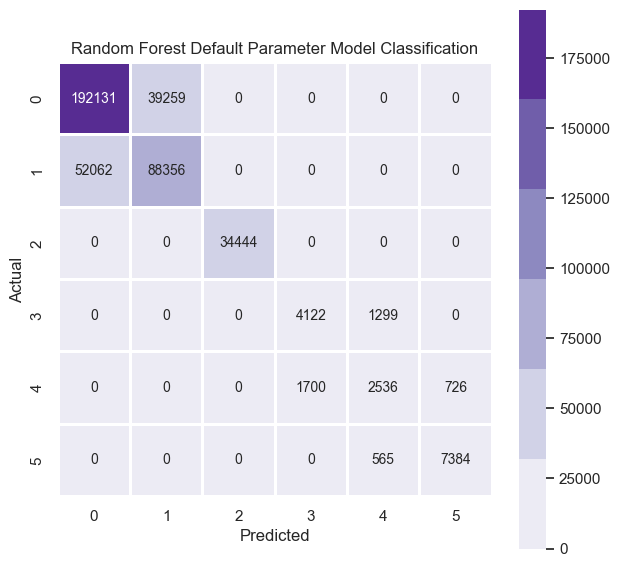

In [5]:
y_pred = rf.predict(X_test).round()

print("Default Decision Tree Model Description")
# print("Depth: %d" % rf.get_depth())
# print("Number of Leaves: %d" % rf.get_n_leaves())
print("*******************************************")
print("Classification Report of the default model")
print(classification_report(y_test, y_pred))

#vizualizing classification report
cmap =sns.color_palette("Purples")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Random Forest Default Parameter Model Classification')
plt.show()

In [6]:
# saving the values in variables to export them later
report_default = classification_report(y_test, y_pred,output_dict=True)
macro_f1_default = report_default['macro avg']['f1-score']
weighted_f1_default = report_default['weighted avg']['f1-score']
class_0_default = report_default['0']['f1-score']
class_1_default = report_default['1']['f1-score']
class_2_default = report_default['2']['f1-score']
class_3_default = report_default['3']['f1-score']
class_4_default = report_default['4']['f1-score']
class_5_default = report_default['5']['f1-score']

#### 5. Hyper-parameter Tuning

Now that the random forest model has proven to produce acceptable performance, we will try to specify its hyper parameters to determine the combination that maxmizes the model's performance score.

Scikit-Learn offers an exhuastive search algorithm enabling us to easily determine the best hyper parameter combination called <b><i>GridSearchCV</i></b>
<br>The algorithm iterate over every combination possible of the input hyper parameter values and select the best one.

The following are the values of hyperparameters tested:
<ol>
<li><b><i>n_estimators</i></b>: 
<br> - [3, 5, 10]
<li><b><i>criterion</i></b>: 
<br> - "gini", "entropy" and "log_loss"
<li><b><i>max_depth</i></b>: 
<br> - [3, 6, 9]
<li><b><i>max_features</i></b>: 
<br> - "sqrt", "log2" and None
</ol>



In [7]:
# specify the value of parameters of interest
tree_params = {'n_estimators':[3, 5, 10],
               'criterion':['gini','entropy', 'log_loss'],
               'max_depth':[3, 6, 9], 
               'max_features':['sqrt', 'log2', None]}

# determine the best hyper parameter
rf_best = GridSearchCV(RandomForestClassifier(), tree_params, cv=5)
# Training the model for classification with the same dataset 
rf_best = rf_best.fit(X_train, y_train)

# Display the best hyperparameters
print("Best hyperparameters for random forest classification: ", rf_best.best_params_)

#saving the model with the best performing hyperparameters
filename = "models/RF_model.pickle"

# save model
pickle.dump(rf_best, open(filename, "wb"))

Best hyperparameters for random forest classification:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'n_estimators': 5}


#### 6. Best Performing Model

The following are the selected hyperparameter values:
<ol>
<li><b><i>criterion</i></b>: log_loss
<li><b><i>max_depth</i></b>: 10
<li><b><i>max_features</i></b>: None
<li><b><i>n_estimators</i></b>: 3
</ol>

With the best hyperparameter combination found in the previous step, we can now build our final random forest classifier and measure its performance.
<br>Using the <i>pickle</i> library, the model with the best hyperparameter is saved to the project file for future use.



Classification Report of the default model
              precision    recall  f1-score   support

           0       0.65      0.97      0.77    231390
           1       0.70      0.13      0.22    140418
           2       1.00      1.00      1.00     34444
           3       0.65      0.96      0.78      5421
           4       0.68      0.27      0.39      4962
           5       0.90      0.94      0.92      7949

    accuracy                           0.68    424584
   macro avg       0.76      0.71      0.68    424584
weighted avg       0.70      0.68      0.61    424584



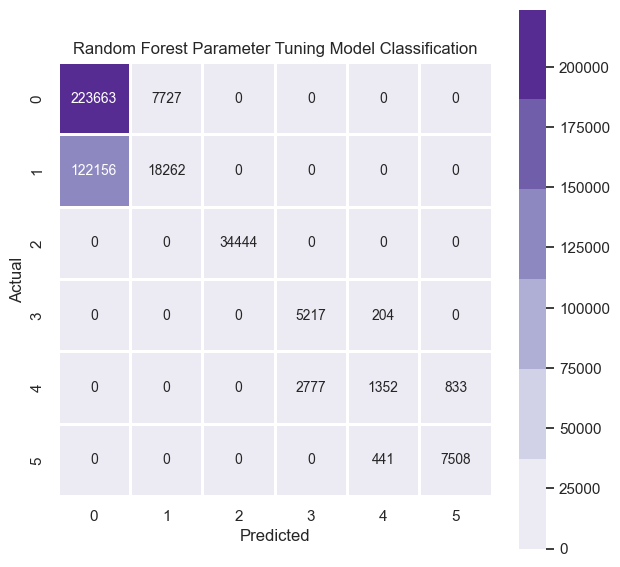

In [8]:
# Measure performance of the model with the best hyper parameter 
y_top_pred = rf_best.predict(X_test)
print("Classification Report of the default model")
report = classification_report(y_test, y_top_pred)
print(report)

#vizualizing classification report
cmap =sns.color_palette("Purples")
cm = confusion_matrix(y_test, y_top_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Random Forest Parameter Tuning Model Classification')
plt.show()

In [9]:
# saving the values in variables to export them later
report_top = classification_report(y_test, y_top_pred,output_dict=True)
macro_f1_top = report_top['macro avg']['f1-score']
weighted_f1_top = report_top['weighted avg']['f1-score']
class_0_top = report_top['0']['f1-score']
class_1_top = report_top['1']['f1-score']
class_2_top = report_top['2']['f1-score']
class_3_top = report_top['3']['f1-score']
class_4_top = report_top['4']['f1-score']
class_5_top = report_top['5']['f1-score']

#### 7.1 Training and Testing the model with Undersampled Data
Draft. Need to re write later
<br> Need to undersample because of imbalance in the data
<br> Only a slight increase in the performance
<br> Testing with undersampled data to figure out

        DateOfCall  PropertyType  NumPumpsAttending  PumpHoursRoundUp  \
100629           1             4                  2                 1   
30999            4            28                  2                 1   
123846           4            40                  3                 2   
169930           7            37                  3                 4   
39290           11            65                  3                 1   

        mean_temp  
100629       11.8  
30999         4.1  
123846       10.3  
169930       22.8  
39290         2.7  
        CostCat
100629        1
30999         0
123846        2
169930        4
39290         0
Random Forest Tree Model Description
*******************************************
Classification Report of the undersampled model
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     22940
           1       0.63      0.56      0.59     14064
           2       1.00      1.00      1.00     10240

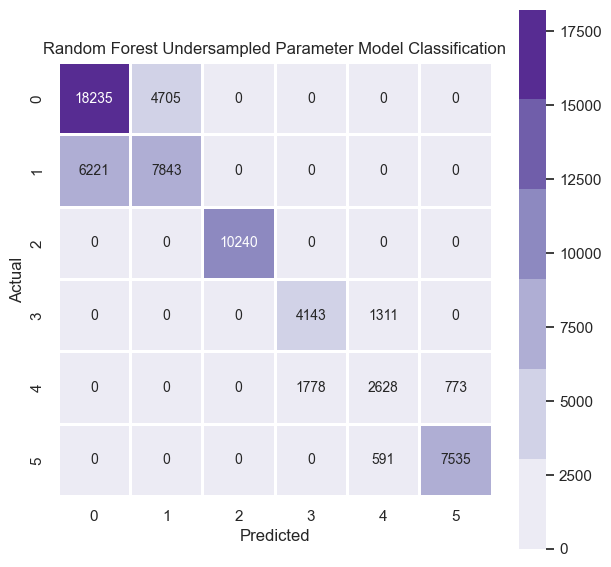

In [11]:
# load dataset, print types
df_undersample = pd.read_csv('preprocessing/data/london_clean_undersample.csv')

# do train and test split
X = df_undersample[['DateOfCall', 'PropertyType', 'NumPumpsAttending', 'PumpHoursRoundUp', 'mean_temp']]
y = df_undersample[['CostCat']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# print a small sample of train X and y
print(X_train[0:5])
print(y_train[0:5])

# create and train decision tree with default model
rf_under_sample = RandomForestClassifier(random_state=42)
rf_under_sample = rf_under_sample.fit(X_train, y_train)

# test
y_pred = rf_under_sample.predict(X_test).round()
print("Random Forest Tree Model Description")
print("*******************************************")
print("Classification Report of the undersampled model")
report = classification_report(y_test, y_pred)
print(report)

#vizualizing classification report
cmap =sns.color_palette("Purples")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Random Forest Undersampled Parameter Model Classification')
plt.show()

# saving the values in variables to export them later
report_under_default = classification_report(y_test, y_pred,output_dict=True)
macro_f1_under_default = report_under_default['macro avg']['f1-score']
weighted_f1_under_default = report_under_default['weighted avg']['f1-score']
class_0_under_default = report_under_default['0']['f1-score']
class_1_under_default = report_under_default['1']['f1-score']
class_2_under_default = report_under_default['2']['f1-score']
class_3_under_default = report_under_default['3']['f1-score']
class_4_under_default = report_under_default['4']['f1-score']
class_5_under_default = report_under_default['5']['f1-score']

#### 7.2 Hyper parameter tuning with undersampled dataset

In [12]:
#specify the value of parameters of interest
tree_params = {'n_estimators':[3, 5, 10],
               'criterion':['gini','entropy', 'log_loss'],
               'max_depth':[3, 6, 9], 
               'max_features':['sqrt', 'log2', None]}

#determine the best hyper parameter
rf_under_top = GridSearchCV(RandomForestClassifier(), tree_params, cv=5)

# Training the model for classification with the same dataset 
rf_under_top = rf_under_top.fit(X_train, y_train)

#saving the model with the best performing hyperparameters
filename = "models/RF_undersample_model.pickle"

# save model
pickle.dump(rf_under_top, open(filename, "wb"))

# Display the best hyperparameters
print("Best hyperparameters for random forest undersampled classification: ", rf_under_top.best_params_)

Best hyperparameters for random forest undersampled classification:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'n_estimators': 10}


Classification Report of the undersampled RF model
              precision    recall  f1-score   support

           0       0.65      0.98      0.78     22940
           1       0.79      0.14      0.24     14064
           2       1.00      1.00      1.00     10240
           3       0.65      0.97      0.78      5454
           4       0.73      0.25      0.38      5179
           5       0.89      0.96      0.92      8126

    accuracy                           0.74     66003
   macro avg       0.78      0.72      0.68     66003
weighted avg       0.77      0.74      0.68     66003



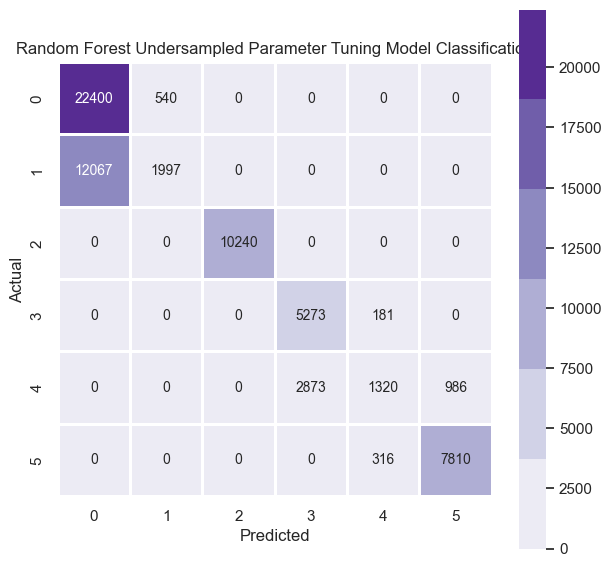

In [14]:
y_top_pred_under = rf_under_top.predict(X_test).round()

print("Classification Report of the undersampled RF model")
print(classification_report(y_test, y_top_pred_under))

#vizualizing classification report
cmap =sns.color_palette("Purples")
cm = confusion_matrix(y_test, y_top_pred_under)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Random Forest Undersampled Parameter Tuning Model Classification')
plt.show()

# saving the values in variables to export them later
report_under_top = classification_report(y_test, y_top_pred_under, output_dict=True)
macro_f1_under_top = report_under_top['macro avg']['f1-score']
weighted_f1_under_top = report_under_top['weighted avg']['f1-score']
class_0_under_top = report_under_top['0']['f1-score']
class_1_under_top = report_under_top['1']['f1-score']
class_2_under_top = report_under_top['2']['f1-score']
class_3_under_top = report_under_top['3']['f1-score']
class_4_under_top = report_under_top['4']['f1-score']
class_5_under_top = report_under_top['5']['f1-score']

### 7. Cross Validation
While GridSearchCV already ran cross-validation, we ran it again testing different folds to make sure the accuracy results are not being influenced by a given split of the data. We observed that the accuracy of the model remains close to the values we obtained with 5-fold GridSearchCV.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

folds = [8, 10]
for i in folds:
    cross_val = KFold(n_splits=i, random_state=42, shuffle=True)
    scores = cross_val_score(rf_top, X, y, scoring='accuracy', cv=cross_val, n_jobs=4)
    print("Testing with {} fold:".format(i))
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Testing with 8 fold:
Accuracy: 0.670 (0.002)
Testing with 10 fold:
Accuracy: 0.669 (0.002)
